# Mitochondria and synapses - Figure S2

In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from scipy.stats import pearsonr, ranksums, ttest_ind

%matplotlib inline

In [21]:
timepoint = [5, 23, 27, 50, 69.5]
bound = [15, 25, 35, 47, 62]
stage_cmap = sns.color_palette("deep",8)
type_cmap = [(253/255, 225/255, 245/255),
             (1, 183/255, 139/255),
             (167/255, 217/255, 245/255)]

## Load data

In [22]:
cell_df = pd.read_csv("neuron_list_hobert.csv")
cell_df.head()

,name,id,type,class,neurotransmitter1,neurotransmitter2,l1_vol,l2_vol,l3_vol,adult_vol,dauer_vol
0,ADAL,1,2,ADA,Glutamate,NaN,0.701728,1.273221,1.371940,3.494185,1.159168
1,ADAR,2,2,ADA,Glutamate,NaN,0.644497,1.260319,1.613807,2.878003,1.017088
2,ADEL,3,1,ADE,Dopamine,NaN,0.364170,1.336320,1.832287,7.324293,0.791347
3,ADER,4,1,ADE,Dopamine,NaN,0.297124,1.328579,1.841921,6.864507,0.781312
4,ADFL,5,1,ADF,Acetylcholine,Serotonin,0.753066,1.446728,2.018413,3.728548,1.827789


In [23]:
l1_mito_df = pd.read_csv("240527_dataset2_mito_neuron.csv")
l2_mito_df = pd.read_csv("240527_dataset5_mito_neuron.csv")
l3_mito_df = pd.read_csv("240527_dataset6_mito_neuron.csv")
adult_mito_df = pd.read_csv("240527_dataset8_mito_neuron.csv")
dauer_mito_df = pd.read_csv("240527_dauer1_mito_neuron.csv")
dauer_mito_df.head()

,cell_name,cell_id,cell_common_id,class,mito_id,cell_vol,mito_vol,cell_surf,mito_surf,x_pos,y_pos,z_pos,mito_len,dist_pre,dist_post
0,AIBR,15,14,2,747,2.679757,0.021658,29.616532,0.372357,5.868936,2.328813,4.282388,1.328166,0.619359,0.666193
1,AIBR,15,14,2,977,2.679757,0.022989,29.616532,0.438184,7.818976,3.981256,5.437973,0.960554,0.472862,0.581278
2,AIBR,15,14,2,1346,2.679757,0.008806,29.616532,0.194831,4.602977,2.567442,7.082849,0.874920,2.611763,0.339316
3,AIBR,15,14,2,1400,2.679757,0.020378,29.616532,0.411419,7.925869,5.646151,7.352387,1.726368,0.232002,0.817458
4,AIBR,15,14,2,2008,2.679757,0.010291,29.616532,0.250027,6.260060,7.735721,10.437065,1.414361,0.206209,0.813789


In [24]:
l1_syn_df = pd.read_csv("240527_dataset2_synapse.csv")
l2_syn_df = pd.read_csv("240527_dataset5_synapse.csv")
l3_syn_df = pd.read_csv("240527_dataset6_synapse.csv")
adult_syn_df = pd.read_csv("240527_dataset8_synapse.csv")
dauer_syn_df = pd.read_csv("240527_dauer1_synapse.csv")
dauer_syn_df.head()

,syn_id,pre,pre_id,pre_common_id,post,post_id,post_common_id,x_pos,y_pos,z_pos,size
0,1,RIH,145,124,CEPDL,187,71,6264,3540,50,56629.85685
1,1,RIH,145,124,OLQDL,189,95,6264,3540,50,115370.14310
2,2,RIH,145,124,URXR,179,181,3312,3848,50,529157.36040
3,2,RIH,145,124,IL2DR,182,88,3312,3848,50,153855.83760
4,2,RIH,145,124,CEPDR,186,72,3312,3848,50,17786.80203


In [90]:
def get_outdeg(syn_df, cellid):
    
    return np.sum(syn_df["pre_common_id"]==cellid)

def get_indeg(syn_df, cellid):
    
    return np.sum(syn_df["post_common_id"]==cellid)

def get_mitovol(mito_df, cellid):
    
    return np.sum(mito_df[mito_df["cell_common_id"]==cellid]["mito_vol"])

def compute_all(df, func):
    
    cell_list = cell_df["id"].values
    n = cell_list.shape[0]
    
    res = np.zeros(n)
    for i in range(n):
        res[i] = func(df, cell_list[i])

    return res

def get_linfit(x, y, xmax):
    
    X = sm.add_constant(x)
    re = sm.OLS(y, X).fit()
    
    xlin = np.linspace(0,xmax,100)
    Xlin = sm.add_constant(xlin)
    dt = re.get_prediction(Xlin).summary_frame(alpha=0.2)
    
    return xlin, dt

def dist(x, y):
    
    x = x.reshape((-1,3))
    y = y.reshape((-1,3))
    
    return np.sum((x-y)**2, axis=1)**0.5

def get_dist_from_syn(syn_df, mito_df, mode="pre"):
    
    if mode=="pre":
        
        syn_id_list = np.unique(syn_df["syn_id"])
        n = syn_id_list.shape[0]
        dist_from_syn = np.zeros(n)
        for i in range(n):
            
            syn_id = syn_id_list[i]
            syn_loc = syn_df[syn_df["syn_id"]==syn_id][["x_pos", "y_pos", "z_pos"]].values[0,:]/1000
            cell_id = syn_df[syn_df["syn_id"]==syn_id]["pre_common_id"].values[0]

            valid = mito_df["cell_common_id"]==cell_id
            if np.sum(valid)==0:
                continue
            mito_loc_list = mito_df[valid][["x_pos", "y_pos", "z_pos"]].values
            dist_list = dist(mito_loc_list, syn_loc)
            dist_from_syn[i] = np.min(dist_list)
            
    elif mode=="post":
        
        n = syn_df.shape[0]
        dist_from_syn = np.zeros(n)
        for i in range(n):
        
            syn_loc = syn_df.iloc[i][["x_pos", "y_pos", "z_pos"]].values/1000
            cell_id = syn_df.iloc[i]["post_common_id"]

            valid = mito_df["cell_common_id"]==cell_id
            if np.sum(valid)==0:
                continue
            mito_loc_list = mito_df[valid][["x_pos", "y_pos", "z_pos"]].values
            dist_list = dist(mito_loc_list, syn_loc)
            dist_from_syn[i] = np.min(dist_list)
    
    return dist_from_syn

In [26]:
l1_outdeg = compute_all(l1_syn_df, get_outdeg)
l2_outdeg = compute_all(l2_syn_df, get_outdeg)
l3_outdeg = compute_all(l3_syn_df, get_outdeg)
adult_outdeg = compute_all(adult_syn_df, get_outdeg)
dauer_outdeg = compute_all(dauer_syn_df, get_outdeg)

In [27]:
l1_indeg = compute_all(l1_syn_df, get_indeg)
l2_indeg = compute_all(l2_syn_df, get_indeg)
l3_indeg = compute_all(l3_syn_df, get_indeg)
adult_indeg = compute_all(adult_syn_df, get_indeg)
dauer_indeg = compute_all(dauer_syn_df, get_indeg)

In [29]:
l1_mitovol = compute_all(l1_mito_df, get_mitovol)
l2_mitovol = compute_all(l2_mito_df, get_mitovol)
l3_mitovol = compute_all(l3_mito_df, get_mitovol)
adult_mitovol = compute_all(adult_mito_df, get_mitovol)
dauer_mitovol = compute_all(dauer_mito_df, get_mitovol)

In [92]:
l1_dist_pre = get_dist_from_syn(l1_syn_df, l1_mito_df, "pre")
l2_dist_pre = get_dist_from_syn(l2_syn_df, l2_mito_df, "pre")
l3_dist_pre = get_dist_from_syn(l3_syn_df, l3_mito_df, "pre")
adult_dist_pre = get_dist_from_syn(adult_syn_df, adult_mito_df, "pre")
dauer_dist_pre = get_dist_from_syn(dauer_syn_df, dauer_mito_df, "pre")

l1_dist_post = get_dist_from_syn(l1_syn_df, l1_mito_df, "post")
l2_dist_post = get_dist_from_syn(l2_syn_df, l2_mito_df, "post")
l3_dist_post = get_dist_from_syn(l3_syn_df, l3_mito_df, "post")
adult_dist_post = get_dist_from_syn(adult_syn_df, adult_mito_df, "post")
dauer_dist_post = get_dist_from_syn(dauer_syn_df, dauer_mito_df, "post")

l1_dist_pre = l1_dist_pre[l1_dist_pre>0]
l2_dist_pre = l2_dist_pre[l2_dist_pre>0]
l3_dist_pre = l3_dist_pre[l3_dist_pre>0]
adult_dist_pre = adult_dist_pre[adult_dist_pre>0]
dauer_dist_pre = dauer_dist_pre[dauer_dist_pre>0]

l1_dist_post = l1_dist_post[l1_dist_post>0]
l2_dist_post = l2_dist_post[l2_dist_post>0]
l3_dist_post = l3_dist_post[l3_dist_post>0]
adult_dist_post = adult_dist_post[adult_dist_post>0]
dauer_dist_post = dauer_dist_post[dauer_dist_post>0]

In [125]:
fs_tick = 12
fs_lab = 14

def plot1(ax, x, y, xticks, yticks, xticklab, yticklab, xlim, ylim, stage):
    
    valid = (x>0)*(y>0)
    x = x[valid]
    y = y[valid]
    
    xlin, dt = get_linfit(x, y, xlim[1])
    
    ax.plot(x, y, "k.",
            alpha=0.6, markeredgewidth=0, markersize=6)
    ax.plot(xlin, dt["mean"], "-", alpha=0.8,
            color=stage_cmap[3])
    plt.fill_between(xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
                     alpha=0.2, color="gray", linewidth=0)
    ax.text(0.02*(xlim[1]-xlim[0]), 0.95*(ylim[1]-ylim[0]), stage, fontsize=fs_lab, fontname="Arial",
            verticalalignment="top")
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_xlabel("Mito. volume ($\mu$m$^3$)", fontsize=fs_lab, fontname="Arial")
    ax.set_ylabel("Out-degree", fontsize=fs_lab, fontname="Arial")
    
def plot2(ax, x, y, xticks, yticks, xticklab, yticklab, xlim, ylim):
    
    valid = (x>0)*(y>0)
    x = x[valid]
    y = y[valid]
    
    xlin, dt = get_linfit(x, y, xlim[1])
    
    ax.plot(x, y, "k.",
            alpha=0.6, markeredgewidth=0, markersize=6)
    ax.plot(xlin, dt["mean"], "-", alpha=0.8,
            color=stage_cmap[3])
    plt.fill_between(xlin, dt["obs_ci_lower"], dt["obs_ci_upper"],
                     alpha=0.2, color="gray", linewidth=0)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_xlabel("Mito. volume ($\mu$m$^3$)", fontsize=fs_lab, fontname="Arial")
    ax.set_ylabel("In-degree", fontsize=fs_lab, fontname="Arial")
    
def plot3(ax, data, cmap, yticks, yticklab, ylim):
    
    xticks = np.arange(2)
    xticklab = ["Pre\nobs", "Post\nobs"]
    
    sns.boxplot(data=data, width=0.5, whis=[5,95],
                showfliers=False,
                palette=[cmap,cmap])
    
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_lab, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_ylabel("$d_{mito}$ ($\mu$m)",
                fontsize=fs_lab, fontname="Arial")

In [129]:
stage_list = ["L1","L2","L3","Adult","Dauer"]

outdeg_list = [l1_outdeg, l2_outdeg, l3_outdeg, adult_outdeg, dauer_outdeg]
indeg_list = [l1_indeg, l2_indeg, l3_indeg, adult_indeg, dauer_indeg]
mitovol_list = [l1_mitovol, l2_mitovol, l3_mitovol, adult_mitovol, dauer_mitovol]

xlim1_list = [(0,0.15), (0,0.42), (0,0.62), (0,0.95), (0,0.42)]
ylim1_list = [(0,75), (0,190), (0,190), (0,330), (0,210)]
xtw1_list = [0.05, 0.1, 0.2, 0.2, 0.1]
ytw1_list = [20, 50, 50, 100, 50]
xticks1_list = [np.arange(xlim1_list[i][0],xlim1_list[i][1],xtw1_list[i]) for i in range(5)]
yticks1_list = [np.arange(ylim1_list[i][0],ylim1_list[i][1],ytw1_list[i]) for i in range(5)]
xticklab1_list = [["0","0.05","0.1"],
                  ["0","0.1","0.2","0.3","0.4"],
                  ["0","0.2","0.4","0.6"],
                  ["0","0.2","0.4","0.6","0.8"],
                  ["0","0.1","0.2","0.3","0.4"]]
yticklab1_list = [["0","20","40","60"],
                  ["0","50","100","150"],
                  ["0","50","100","150"],
                  ["0","100","200","300"],
                  ["0","50","100","150","200"]]

xlim2_list = [(0,0.15), (0,0.42), (0,0.62), (0,0.95), (0,0.42)]
ylim2_list = [(0,58), (0,145), (0,145), (0,260), (0,160)]
xtw2_list = [0.05, 0.1, 0.2, 0.2, 0.1]
ytw2_list = [20, 50, 50, 100, 50]
xticks2_list = [np.arange(xlim2_list[i][0],xlim2_list[i][1],xtw2_list[i]) for i in range(5)]
yticks2_list = [np.arange(ylim2_list[i][0],ylim2_list[i][1],ytw2_list[i]) for i in range(5)]
xticklab2_list = [["0","0.05","0.1"],
                  ["0","0.1","0.2","0.3","0.4"],
                  ["0","0.2","0.4","0.6"],
                  ["0","0.2","0.4","0.6","0.8"],
                  ["0","0.1","0.2","0.3","0.4"]]
yticklab2_list = [["0","20","40"],
                  ["0","50","100"],
                  ["0","50","100"],
                  ["0","100","200"],
                  ["0","50","100","150"]]

dist_list = [[l1_dist_pre,l1_dist_post],
             [l2_dist_pre,l2_dist_post],
             [l3_dist_pre,l3_dist_post],
             [adult_dist_pre,adult_dist_post],
             [dauer_dist_pre,dauer_dist_post]]

ylim3_list = [(0,7.9), (0,16), (0,7.5), (0,9), (0,4.5)]
ytw3_list = [2, 5, 2, 2, 1]
yticks3_list = [np.arange(ylim3_list[i][0],ylim3_list[i][1],ytw3_list[i]) for i in range(5)]
yticklab3_list = [["0","2","4","6"],
                  ["0","5","10","15"],
                  ["0","2","4","6"],
                  ["0","2","4","6","8"],
                  ["0","1","2","3","4"]]

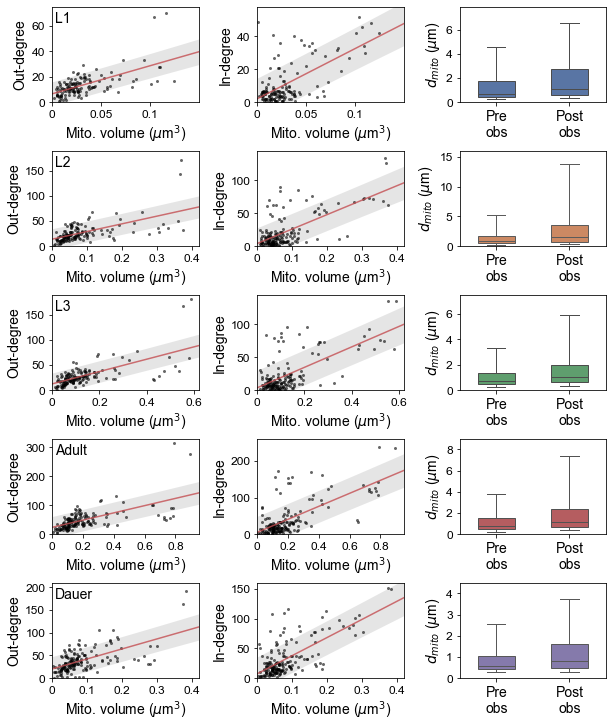

In [131]:
fig = plt.figure(figsize=(8.4,10), constrained_layout=True)
gs = fig.add_gridspec(5,3,wspace=0.05)

for i in range(5):
    ax = fig.add_subplot(gs[i,0])
    plot1(ax, mitovol_list[i], outdeg_list[i],
         xticks1_list[i], yticks1_list[i],
         xticklab1_list[i], yticklab1_list[i],
         xlim1_list[i], ylim1_list[i], stage_list[i])
    
for i in range(5):
    ax = fig.add_subplot(gs[i,1])
    plot2(ax, mitovol_list[i], indeg_list[i],
         xticks2_list[i], yticks2_list[i],
         xticklab2_list[i], yticklab2_list[i],
         xlim2_list[i], ylim2_list[i])
    
for i in range(5):
    ax = fig.add_subplot(gs[i,2])
    plot3(ax, dist_list[i], stage_cmap[i],
          yticks3_list[i], yticklab3_list[i], ylim3_list[i])

plt.savefig("/home/jabae/Dropbox/SNU/Research/Celegans/Cmito/figures/figure_v2/panels/figS2.svg")
plt.show()

In [138]:
print("Out-degree\n")
for i in range(5):
    
    valid = (mitovol_list[i]>0)*(outdeg_list[i]>0)
    x = mitovol_list[i][valid]
    y = outdeg_list[i][valid]
    
    r, p = pearsonr(x, y)
    print(f"{stage_list[i]}: r={r}, p={p}")

Out-degree

L1: r=0.6231673016072565, p=6.961502473013196e-16
L2: r=0.601019497515992, p=4.246015697530347e-16
L3: r=0.6623503948355971, p=1.5054327882171635e-20
Adult: r=0.6180346580936948, p=2.4587861747351174e-18
Dauer: r=0.5946155352587945, p=4.6766117818519634e-17


In [139]:
print("In-degree\n")
for i in range(5):
    
    valid = (mitovol_list[i]>0)*(indeg_list[i]>0)
    x = mitovol_list[i][valid]
    y = indeg_list[i][valid]
    
    r, p = pearsonr(x, y)
    print(f"{stage_list[i]}: r={r}, p={p}")

In-degree

L1: r=0.6391371295461136, p=1.9333184161035187e-17
L2: r=0.6722416259325027, p=1.929344605662334e-23
L3: r=0.6599147189682973, p=5.416808624713703e-22
Adult: r=0.6774715317257851, p=2.157189490135353e-25
Dauer: r=0.6914202254907424, p=1.2208718750307168e-26


In [135]:
print("Distance to synapse\n")
for i in range(5):
    
    r, p = ranksums(dist_list[i][0],dist_list[i][1])
    print(f"{stage_list[i]}: p={p}")

Distance to synapse

L1: p=1.4363249706593423e-20
L2: p=1.1337320993465531e-84
L3: p=1.2032616393836824e-55
Adult: p=7.706115122933304e-141
Dauer: p=7.83073660325607e-52
